In [96]:
#import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import numpy as np
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from scipy.stats import poisson, uniform
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier

[nltk_data] Downloading package punkt to C:\Users\Josiah
[nltk_data]     Lee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Josiah
[nltk_data]     Lee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [97]:
data = pd.DataFrame(pd.read_csv('../Twitter Sentiment/cleanedNspelt.csv'))

def helper(string):
    temp = []
    for word in string[1:-1].split(','):
        word = word.strip()
        word = word[1:-1]
        if word:
          temp.append(word)  
    return temp
data.filtered_tokens = data.filtered_tokens.apply(helper)

Use if machine not strong

In [98]:
#data = data.iloc[25000:75000]

In [99]:
X_train, X_test, y_train, y_test = train_test_split(data.filtered_tokens, data.labels, stratify = data.labels, test_size=0.2, random_state=42)

In [100]:
vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2), stop_words='english')
sentences = [' '.join(words) for words in X_train]

# Fit and transform the sentences
one_hot_encoded = vectorizer.fit_transform(sentences)

Baseline Model when K = 1000 to find optimal parameters for RF

In [101]:
test1 = SelectKBest(score_func=chi2, k=1000)

X_train_new = test1.fit_transform(one_hot_encoded, y_train)

In [102]:
rf = RandomForestClassifier()
distributions = {'n_estimators': poisson(50), 'max_depth': poisson(10)}
rscv = RandomizedSearchCV(rf, distributions, random_state=42, n_jobs=-1, verbose=2, n_iter = 30)
rscv.fit(X_train_new, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020505CCE380>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020505CCE770>},
                   random_state=42, verbose=2)

In [103]:
rscv.best_estimator_

RandomForestClassifier(max_depth=18, n_estimators=50)

In [104]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test1.transform(X_test_new)

In [105]:
y_pred = rscv.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more details
print(classification_report(y_test, y_pred))


Accuracy: 0.70
              precision    recall  f1-score   support

           0       0.77      0.57      0.66     10000
           1       0.66      0.83      0.74     10000

    accuracy                           0.70     20000
   macro avg       0.72      0.70      0.70     20000
weighted avg       0.72      0.70      0.70     20000



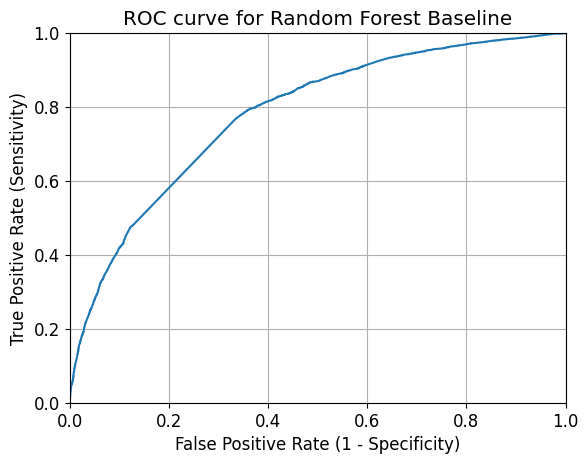

In [106]:
y_pred_prob = rscv.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Random Forest Baseline')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [107]:
print(f"ROC AUC score: {roc_auc_score(y_test, y_pred_prob)}")

ROC AUC score: 0.779886305


From our small RandomisedSearchCV, we see that the best hyperparameters for our model is when max_depth = 18 and number of estimators = 50, given our assumption of the underlying distributions of the models.

Now we try different number of columns selected by chi2 starting with 100

In [108]:
test2 = SelectKBest(score_func=chi2, k=100)

X_train_new = test2.fit_transform(one_hot_encoded, y_train)
clf2 = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42, n_jobs = -1)
clf2.fit(X_train_new, y_train)

RandomForestClassifier(max_depth=18, n_estimators=50, n_jobs=-1,
                       random_state=42)

As we can see, accuracy has dipped slightly showing that having more columns might increase accuracy. Hence we attempt to prove this hypothesis by adding more columns.

Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.77      0.52      0.62     10000
           1       0.64      0.84      0.72     10000

    accuracy                           0.68     20000
   macro avg       0.70      0.68      0.67     20000
weighted avg       0.70      0.68      0.67     20000

ROC AUC score:0.7562451649999999


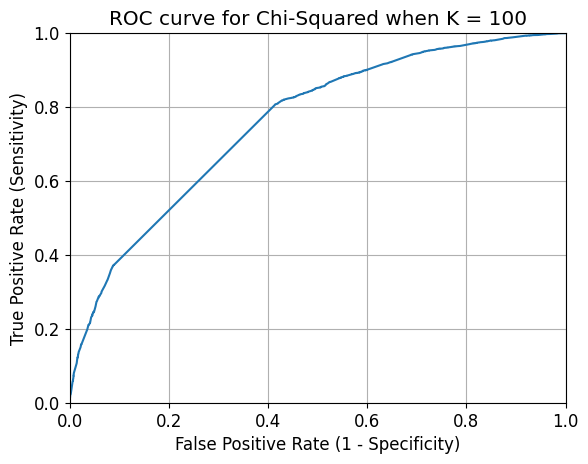

In [109]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test2.transform(X_test_new)
y_pred = clf2.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more details
print(classification_report(y_test, y_pred))
y_pred_prob = clf2.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Chi-Squared when K = 100')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(f'ROC AUC score:{roc_auc_score(y_test, y_pred_prob)}')

Now we try to select the best 10000 columns

In [110]:
test3 = SelectKBest(score_func=chi2, k=10000)

X_train_new = test3.fit_transform(one_hot_encoded, y_train)
clf3 = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42, n_jobs = -1)
clf3.fit(X_train_new, y_train)

RandomForestClassifier(max_depth=18, n_estimators=50, n_jobs=-1,
                       random_state=42)

Accuracy: 0.71
              precision    recall  f1-score   support

           0       0.77      0.60      0.67     10000
           1       0.67      0.82      0.74     10000

    accuracy                           0.71     20000
   macro avg       0.72      0.71      0.71     20000
weighted avg       0.72      0.71      0.71     20000

ROC AUC score:0.785252415


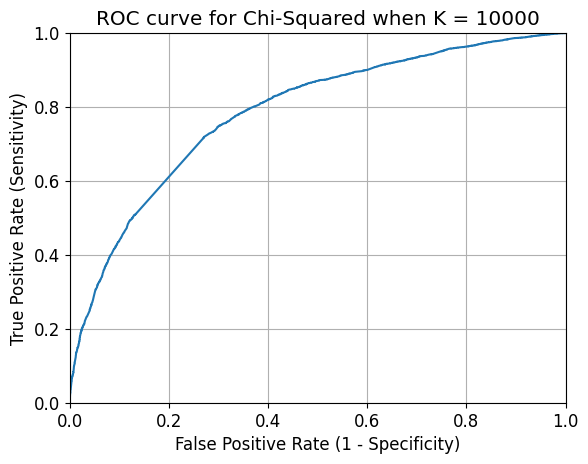

In [111]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test3.transform(X_test_new)
y_pred = clf3.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more details
print(classification_report(y_test, y_pred))
y_pred_prob = clf3.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Chi-Squared when K = 10000')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(f'ROC AUC score:{roc_auc_score(y_test, y_pred_prob)}')

Same can be said when number of columns selected is 20000 by the increases in accuracy are diminishing.

In [112]:
test4 = SelectKBest(score_func=chi2, k=20000)

X_train_new = test4.fit_transform(one_hot_encoded, y_train)
clf4 = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42, n_jobs = -1)
clf4.fit(X_train_new, y_train)

RandomForestClassifier(max_depth=18, n_estimators=50, n_jobs=-1,
                       random_state=42)

Accuracy: 0.72
              precision    recall  f1-score   support

           0       0.77      0.63      0.69     10000
           1       0.69      0.82      0.75     10000

    accuracy                           0.72     20000
   macro avg       0.73      0.72      0.72     20000
weighted avg       0.73      0.72      0.72     20000

ROC AUC score:0.7965551399999999


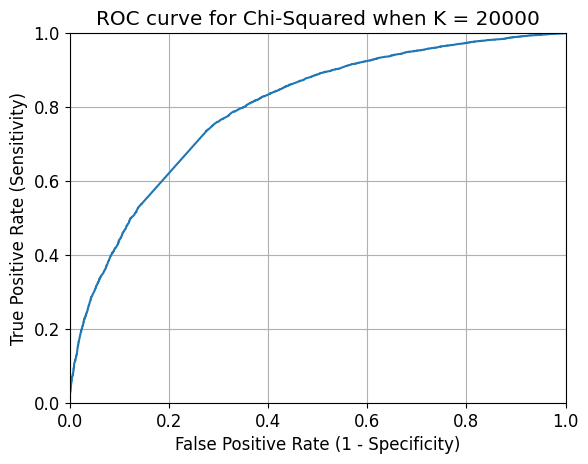

In [113]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test4.transform(X_test_new)
y_pred = clf4.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more details
print(classification_report(y_test, y_pred))
y_pred_prob = clf4.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Chi-Squared when K = 20000')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(f'ROC AUC score:{roc_auc_score(y_test, y_pred_prob)}')

In [114]:
test5 = SelectKBest(score_func=chi2, k=30000)

X_train_new = test5.fit_transform(one_hot_encoded, y_train)
clf5 = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42, n_jobs = -1)
clf5.fit(X_train_new, y_train)

RandomForestClassifier(max_depth=18, n_estimators=50, n_jobs=-1,
                       random_state=42)

Accuracy: 0.72
              precision    recall  f1-score   support

           0       0.76      0.64      0.70     10000
           1       0.69      0.80      0.74     10000

    accuracy                           0.72     20000
   macro avg       0.73      0.72      0.72     20000
weighted avg       0.73      0.72      0.72     20000

ROC AUC score:0.7895061800000001


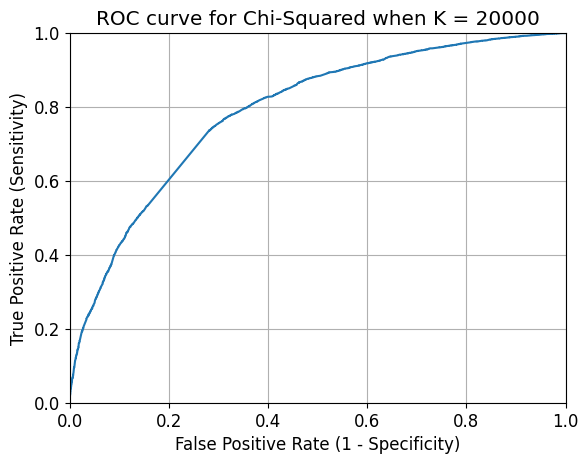

In [115]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test5.transform(X_test_new)
y_pred = clf5.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more details
print(classification_report(y_test, y_pred))
y_pred_prob = clf5.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Chi-Squared when K = 20000')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(f'ROC AUC score:{roc_auc_score(y_test, y_pred_prob)}')

Apart from chi2 we try other alternative methods for decomposition of our data, here we try truncated SVD which is more suitable as our data is very large and sparse

In [116]:
# Create a PCA instance
SVD = TruncatedSVD(n_components=100)

# Fit and transform your one-hot encoded data
SVD.fit(one_hot_encoded)

explained_variance = SVD.explained_variance_

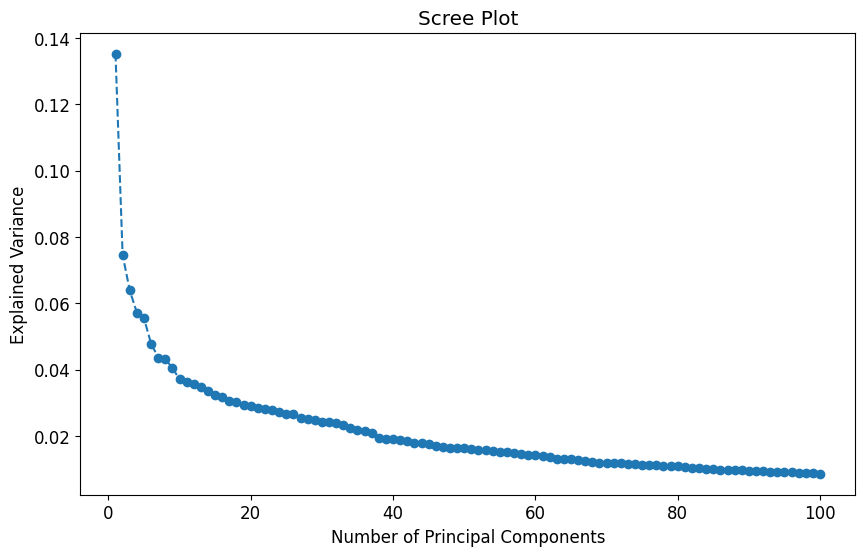

In [117]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.show()

From the scree plot, we can see that the kink is around where the number of principal components is 20, hence we use this number going forward.

In [118]:
SVD = TruncatedSVD(n_components=20)
X_train_new = SVD.fit_transform(one_hot_encoded)
rf_classifier = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42)
rf_classifier.fit(X_train_new, y_train)

RandomForestClassifier(max_depth=18, n_estimators=50, random_state=42)

In [119]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = SVD.transform(X_test_new)
y_pred = rf_classifier.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more details
print(classification_report(y_test, y_pred))

Accuracy: 0.69
              precision    recall  f1-score   support

           0       0.71      0.66      0.68     10000
           1       0.68      0.73      0.70     10000

    accuracy                           0.69     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.69      0.69      0.69     20000



ROC AUC score:0.76493484


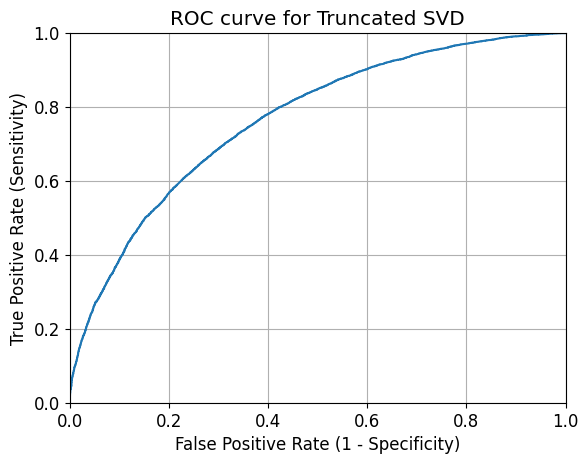

In [120]:
y_pred_prob = rf_classifier.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Truncated SVD')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(f'ROC AUC score:{roc_auc_score(y_test, y_pred_prob)}')

We can see that TruncatedSVD seems to perfrom slightly worse, next we try tfidf

In [121]:
# TF-IDF
sentences = [' '.join(words) for words in X_train]

tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)

In [122]:
clf = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42, n_jobs=-1)
clf.fit(tfidf_matrix,y_train)

RandomForestClassifier(max_depth=18, n_estimators=50, n_jobs=-1,
                       random_state=42)

Accuracy: 0.69765
              precision    recall  f1-score   support

           0       0.77      0.56      0.65     10000
           1       0.66      0.83      0.73     10000

    accuracy                           0.70     20000
   macro avg       0.71      0.70      0.69     20000
weighted avg       0.71      0.70      0.69     20000

ROC AUC score:0.7754476800000001


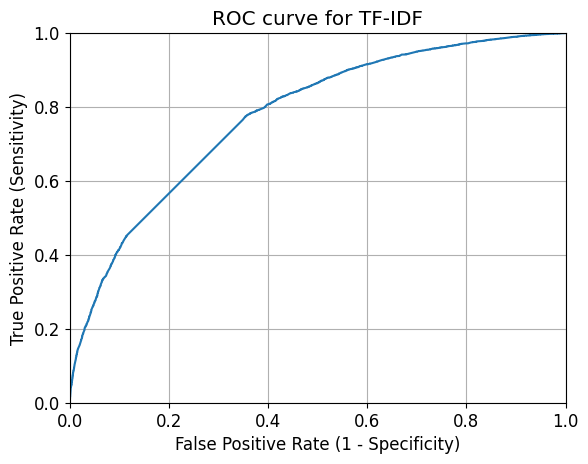

In [123]:
sen = [' '.join(words) for words in X_test]
X_test_new = tfidf_vectorizer.transform(sen)
y_pred = clf.predict(X_test_new)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(report)

y_pred_prob = clf.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for TF-IDF')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(f'ROC AUC score:{roc_auc_score(y_test, y_pred_prob)}')

We see that chi2 shows the best performance given our different feature selection methods. We can see that there seems to be a positive relation between the amount of columns selected and accuracy but with diminishing marginal returns. In light of the constraints in computing power, we felt that having 10000 columns would be best taking performance and computing constraints into account.

Now we are trying out different models and comparing it to our baseline. Firstly we have LogReg

In [124]:
vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2), stop_words='english')
sentences = [' '.join(words) for words in X_train]

# Fit and transform the sentences
one_hot_encoded = vectorizer.fit_transform(sentences)

In [125]:
test = SelectKBest(score_func=chi2, k=10000)
X_train_new = test.fit_transform(one_hot_encoded, y_train)
clf = LogisticRegression(random_state = 42, max_iter=1000, penalty = 'l2', C = 1, solver = 'saga')
clf.fit(X_train_new, y_train)

LogisticRegression(C=1, max_iter=1000, random_state=42, solver='saga')

Accuracy: 0.7586
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75     10000
           1       0.74      0.79      0.77     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

ROC AUC score:0.8286908650000001


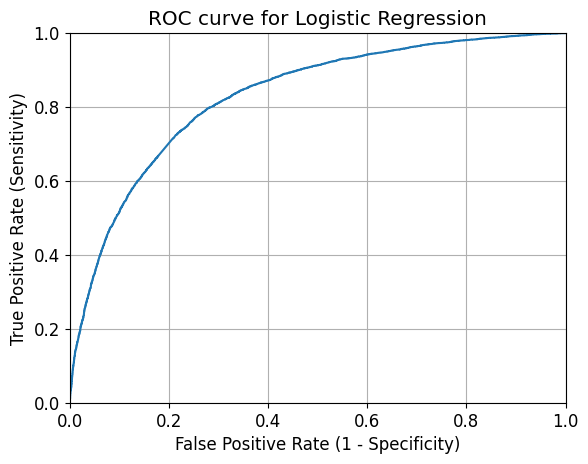

In [126]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test.transform(X_test_new)
y_pred = clf.predict(X_test_new)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

y_pred_prob = clf.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(f'ROC AUC score:{roc_auc_score(y_test, y_pred_prob)}')

In [127]:
lrcv = LogisticRegressionCV(random_state=42, verbose=2, n_jobs = -1, solver = 'saga', max_iter=500)
lrcv.fit(X_train_new, y_train)

rescaling...rescaling...
rescaling...
rescaling...
rescaling...

rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...

c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 14 seconds
max_iter reached after 14 seconds


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 14 seconds
max_iter reached after 14 seconds


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 14 seconds


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 14 seconds
max_iter reached after 14 seconds


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 14 seconds
max_iter reached after 14 seconds


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 14 seconds


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 14 seconds


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 15 seconds


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 14 seconds
max_iter reached after 15 seconds


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 14 seconds
max_iter reached after 14 seconds


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.0min remaining:   41.5s
c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


max_iter reached after 13 seconds


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


max_iter reached after 8 seconds


c:\Users\Josiah Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegressionCV(max_iter=500, n_jobs=-1, random_state=42, solver='saga',
                     verbose=2)

In [128]:
lrcv.scores_

{1: array([[0.66275  , 0.694625 , 0.7285625, 0.7521875, 0.7678125, 0.7816875,
         0.7834375, 0.7833125, 0.7835625, 0.784    ],
        [0.665125 , 0.69575  , 0.7358125, 0.7570625, 0.774625 , 0.7839375,
         0.7841875, 0.7835   , 0.784    , 0.7839375],
        [0.667625 , 0.7000625, 0.738    , 0.7616875, 0.7790625, 0.7871875,
         0.7884375, 0.7884375, 0.788125 , 0.787875 ],
        [0.6669375, 0.6954375, 0.731125 , 0.756625 , 0.7744375, 0.78375  ,
         0.7859375, 0.786375 , 0.7863125, 0.78625  ],
        [0.6625625, 0.693125 , 0.728375 , 0.7535625, 0.7705625, 0.7805625,
         0.7855625, 0.785125 , 0.78525  , 0.7855625]])}

Accuracy: 0.7393
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.71      0.73     10000
           1       0.72      0.77      0.75     10000

    accuracy                           0.74     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.74      0.74      0.74     20000

ROC AUC score:0.787261325


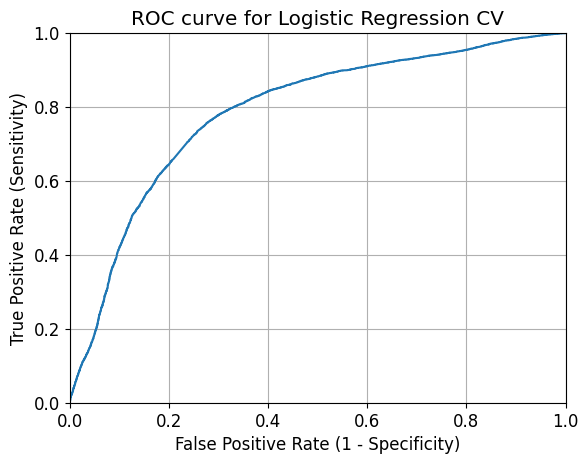

In [129]:
y_pred = lrcv.predict(X_test_new)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

y_pred_prob = lrcv.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Logistic Regression CV')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(f'ROC AUC score:{roc_auc_score(y_test, y_pred_prob)}')

Next we have Naive Bayes

In [130]:
clf = BernoulliNB()
clf.fit(X_train_new, y_train)

BernoulliNB()

Accuracy: 0.74765
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74     10000
           1       0.73      0.78      0.76     10000

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

ROC AUC score:0.8157269149999999


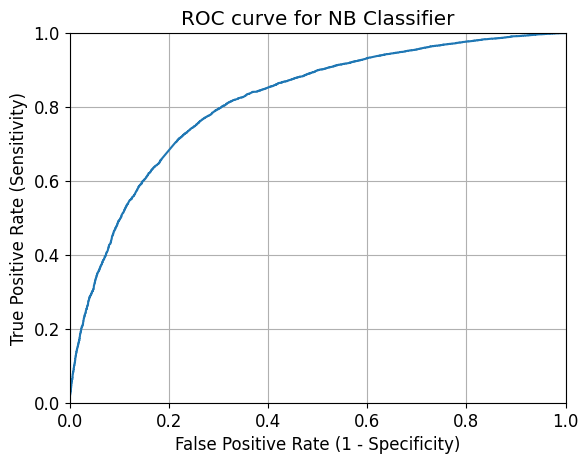

In [131]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test.transform(X_test_new)
y_pred = clf.predict(X_test_new)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

y_pred_prob = clf.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for NB Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print(f'ROC AUC score:{roc_auc_score(y_test, y_pred_prob)}')

In [132]:
cv_results = cross_validate(clf, X_train_new, y_train, cv = 5, n_jobs=-1)

In [133]:
print(f"Accuracy score after CV: {cv_results['test_score'].mean()}")

Accuracy score after CV: 0.7826000000000001


After comparing all the different models we try to combine all of the models into 1.

In [134]:
test = SelectKBest(score_func=chi2, k=10000)
X_train_new = test.fit_transform(one_hot_encoded, y_train)

In [135]:
clf1 = BernoulliNB()
clf2 = LogisticRegression(random_state = 42, penalty = 'l2', C = 1, solver = 'saga')
clf3 = RandomForestClassifier(n_estimators=50, max_depth=18, random_state=42)

In [136]:
eclf1 = VotingClassifier(estimators=[('nb', clf1), ('lr', clf2), ('rf', clf3)], voting='soft', n_jobs=-1)
eclf1.fit(X_train_new, y_train)

VotingClassifier(estimators=[('nb', BernoulliNB()),
                             ('lr',
                              LogisticRegression(C=1, random_state=42,
                                                 solver='saga')),
                             ('rf',
                              RandomForestClassifier(max_depth=18,
                                                     n_estimators=50,
                                                     random_state=42))],
                 n_jobs=-1, voting='soft')

Accuracy: 0.7554
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.72      0.75     10000
           1       0.74      0.79      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

ROC AUC score: 0.8267920449999999


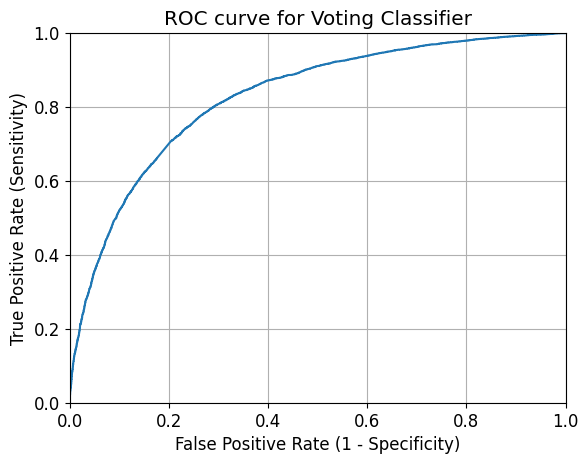

In [137]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test.transform(X_test_new)
y_pred = eclf1.predict(X_test_new)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

y_pred_prob = eclf1.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

print(f"ROC AUC score: {roc_auc_score(y_test, y_pred_prob)}")

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Voting Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

We try to run CV on our model to tune the hyperparameters

In [138]:
eclf1.get_params()

{'estimators': [('nb', BernoulliNB()),
  ('lr', LogisticRegression(C=1, random_state=42, solver='saga')),
  ('rf',
   RandomForestClassifier(max_depth=18, n_estimators=50, random_state=42))],
 'flatten_transform': True,
 'n_jobs': -1,
 'verbose': False,
 'voting': 'soft',
 'weights': None,
 'nb': BernoulliNB(),
 'lr': LogisticRegression(C=1, random_state=42, solver='saga'),
 'rf': RandomForestClassifier(max_depth=18, n_estimators=50, random_state=42),
 'nb__alpha': 1.0,
 'nb__binarize': 0.0,
 'nb__class_prior': None,
 'nb__fit_prior': True,
 'nb__force_alpha': 'warn',
 'lr__C': 1,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': 42,
 'lr__solver': 'saga',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf_

In [139]:
distributions = {'lr__penalty':['l1', 'l2'], 'rf__n_estimators':poisson(mu = 20), 'lr__C':uniform(loc = 0, scale = 1.5)}

In [140]:
rscv = RandomizedSearchCV(eclf1, distributions, random_state=42, verbose=2, n_jobs = -1)
rscv.fit(X_train_new, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=VotingClassifier(estimators=[('nb', BernoulliNB()),
                                                          ('lr',
                                                           LogisticRegression(C=1,
                                                                              random_state=42,
                                                                              solver='saga')),
                                                          ('rf',
                                                           RandomForestClassifier(max_depth=18,
                                                                                  n_estimators=50,
                                                                                  random_state=42))],
                                              n_jobs=-1, voting='soft'),
                   n_jobs=-1,
                   param_distributions={'lr__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000205031E8A90>,
                                        'lr__penalty': ['l1', 'l2'],
                                        'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000205022E7A30>},
                   random_state=42, verbose=2)

In [141]:
rscv.best_estimator_

VotingClassifier(estimators=[('nb', BernoulliNB()),
                             ('lr',
                              LogisticRegression(C=1.4133026335272791,
                                                 random_state=42,
                                                 solver='saga')),
                             ('rf',
                              RandomForestClassifier(max_depth=18,
                                                     n_estimators=24,
                                                     random_state=42))],
                 n_jobs=-1, voting='soft')

In [142]:
rscv.cv_results_['mean_test_score']

array([0.77925  , 0.7840875, 0.78505  , 0.77895  , 0.778475 , 0.7758625,
       0.780725 , 0.7830625, 0.780525 , 0.7852875])

Accuracy: 0.7555
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75     10000
           1       0.74      0.78      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

ROC AUC score: 0.8256933249999999


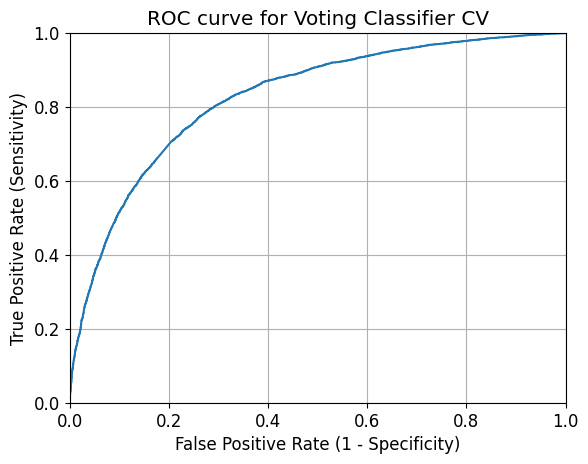

In [143]:
y_pred = rscv.predict(X_test_new)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

y_pred_prob = rscv.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

print(f"ROC AUC score: {roc_auc_score(y_test, y_pred_prob)}")

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Voting Classifier CV')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

We have trained our own in house model and see how it compares to the state of the art model like XGBoost

In [144]:
test = SelectKBest(score_func=chi2, k=10000)
X_train_new = test.fit_transform(one_hot_encoded, y_train)

clf = XGBClassifier(max_depth=6, objective='binary:logistic', n_estimators = 800)
clf.fit(X_train_new, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Accuracy: 0.75915
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75     10000
           1       0.74      0.79      0.77     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

ROC AUC score: 0.83158904


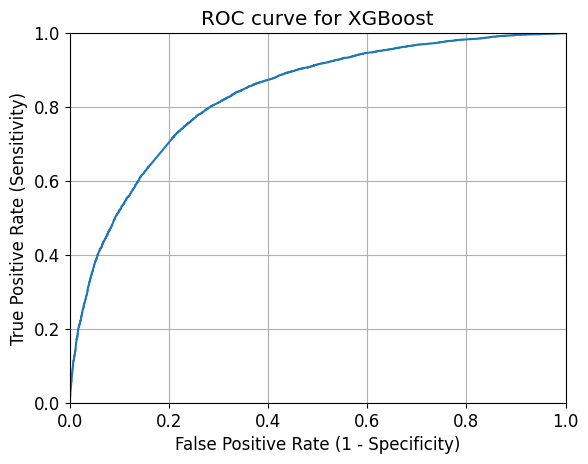

In [145]:
sen = [' '.join(words) for words in X_test]
X_test_new = vectorizer.transform(sen)
X_test_new = test.transform(X_test_new)
y_pred = clf.predict(X_test_new)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

y_pred_prob = clf.predict_proba(X_test_new)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

print(f"ROC AUC score: {roc_auc_score(y_test, y_pred_prob)}")

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for XGBoost')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)